# Construct Survey Footprint Data

It is useful to take the footprints of previous surveys into account when developing a new survey, to maximize the science possible from the combined data products. However, the pointing data from different surveys tends to be available in different form.  In this notebook, we convert the provided data into a conherent set of tables. 

## The Blanco DECam Bulge Survey

See Rich, R.M. et al (2008), MNRAS, 499, 2340. 
Table 1 of this paper provides a list of the pointings for each observation in the survey.  The full table was kindly provided by author Mike Rich in latex format.  

In [8]:
from os import path
import csv
import json
from astropy import units as u 
from mw_plot import MWSkyMap
import matplotlib.pyplot as plt
import numpy as np
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord, ICRS
%matplotlib inline
import healpy as hp

The table includes the following columns: date_obs, RA, Dec, exposure time, filter, filename. 

In [49]:
input_file = '/Users/rstreet/LSST/Follow_Up/Rich_BDBS_obs_catalog_edit2.tex'

with open(input_file) as f:
    filelines = f.readlines() 

data = {}
for line in filelines:
    entries = line.replace('\\\n', '').replace('\t','').split('&')
    # Sort the pointing entries by filter, in case the footprints are different 
    if entries[4] in data.keys():
        pointing_set = data[entries[4]]
    else:
        pointing_set = []
    pointing_set.append([float(entries[1]), float(entries[2])])
    data[entries[4]] = pointing_set

for f, pointing_set in data.items():
    print(str(len(pointing_set)) + ' observations in filter ' + f)

1318 observations in filter i
1576 observations in filter r
1120 observations in filter Y
1165 observations in filter z
1229 observations in filter g
1136 observations in filter u


Since the BDBS was a time-domain survey, there are likely duplicated entries in these arrays, so we filter these out for easier handling.

In [51]:
pointings = SkyCoord(np.array(data['i'])[:,0], np.array(data['i'])[:,1], frame='icrs', unit=(u.deg, u.deg))

bdbs_footprint = {}

for f in data.keys():
    uniqs = []
    uniq_pointings = []
    for i in range(0,len(data[f]),1):
        entry = data[f][i]
        
        s = SkyCoord(entry[0], entry[1], frame='icrs', unit=(u.deg, u.deg))
        
        if i == 0:
            uniq_pointings.append(entry)
        else:
            uniqs = SkyCoord(np.array(uniq_pointings)[:,0], np.array(uniq_pointings)[:,1], frame='icrs', unit=(u.deg, u.deg))
            sep = s.separation(uniqs)
            idx = np.where(sep.value <= 0.5)[0]
            if len(idx) == 0:
                uniq_pointings.append(entry)

    bdbs_footprint[f] = uniq_pointings

for f, pointing_set in bdbs_footprint.items():
    print(str(len(pointing_set)) + ' unique pointings in filter ' + f)

131 unique pointings in filter i
136 unique pointings in filter r
128 unique pointings in filter Y
129 unique pointings in filter z
132 unique pointings in filter g
129 unique pointings in filter u


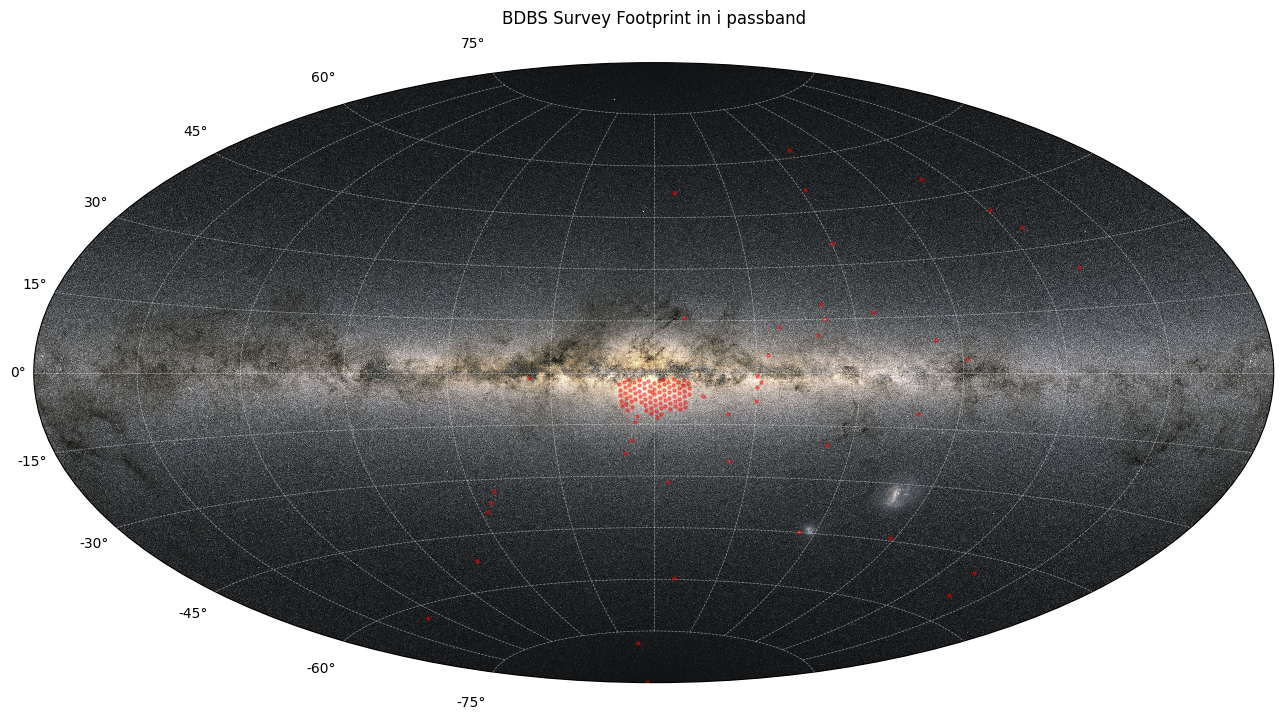

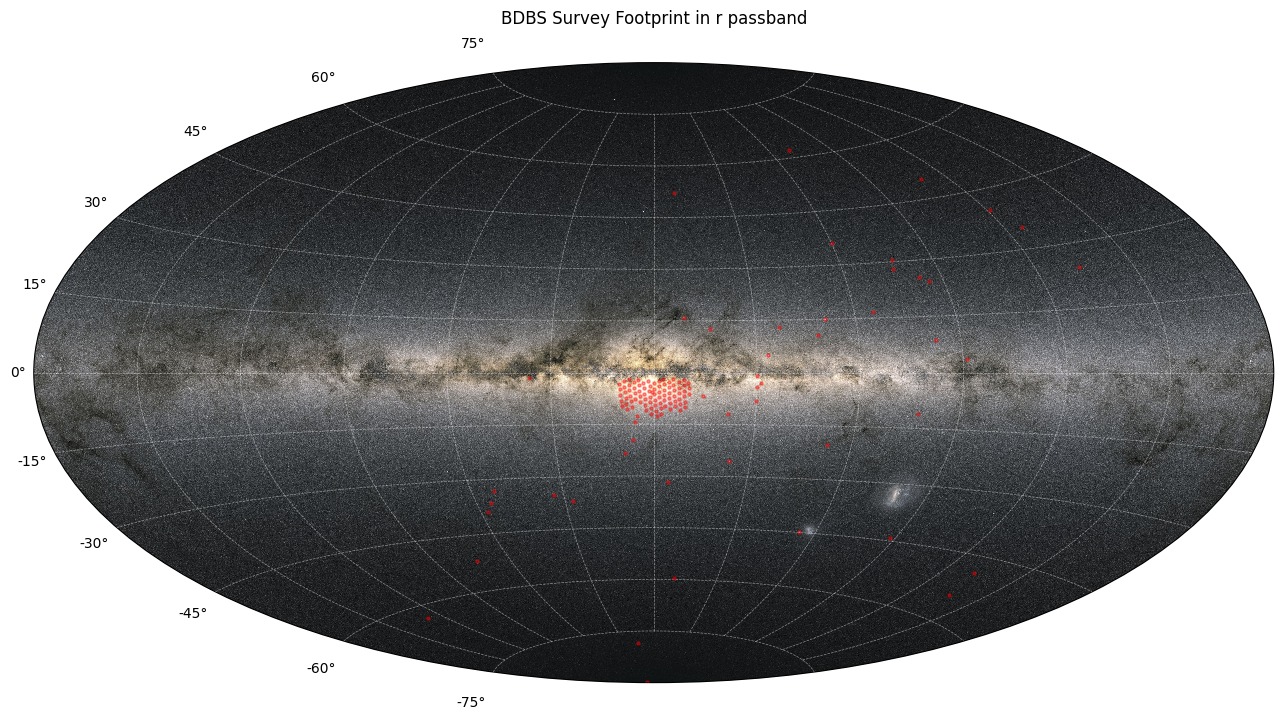

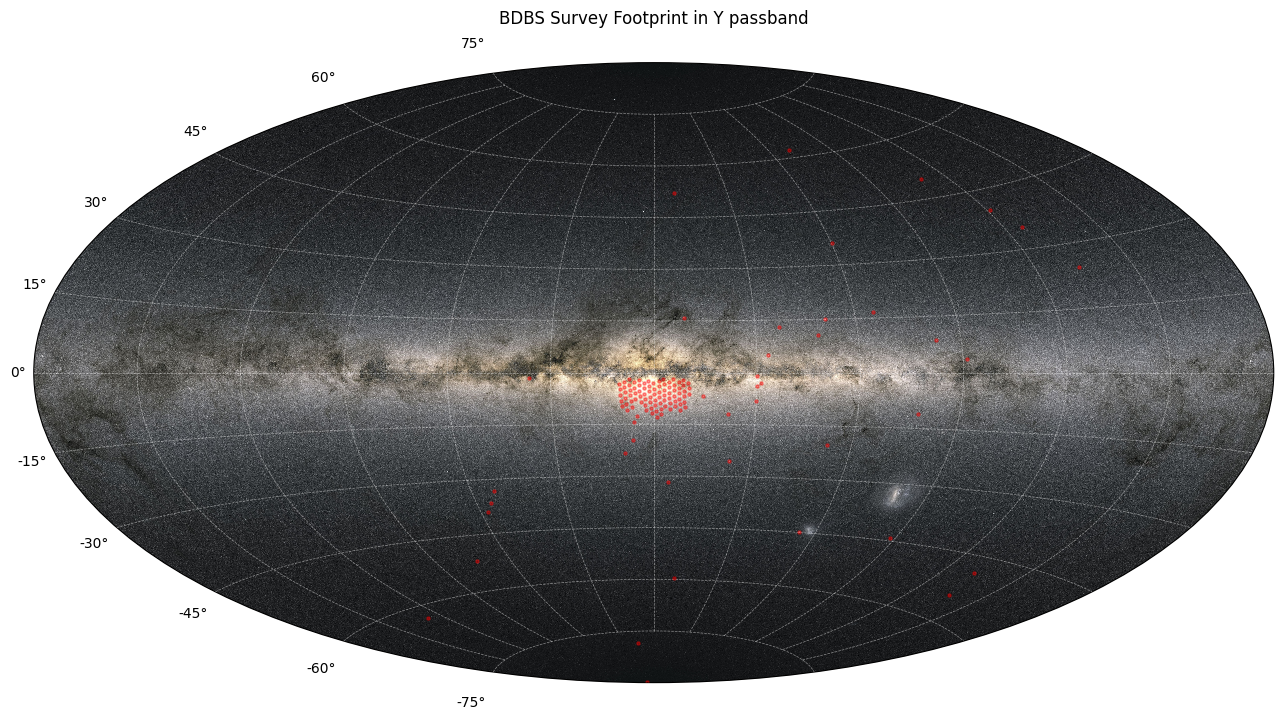

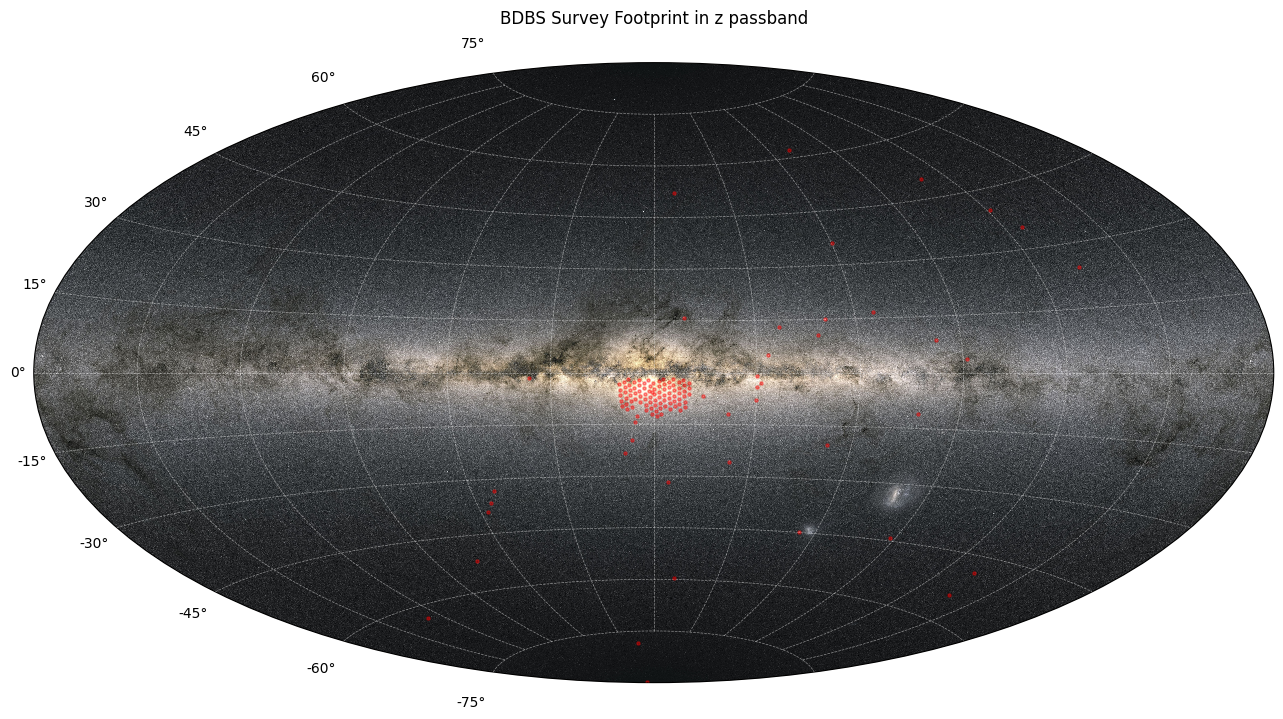

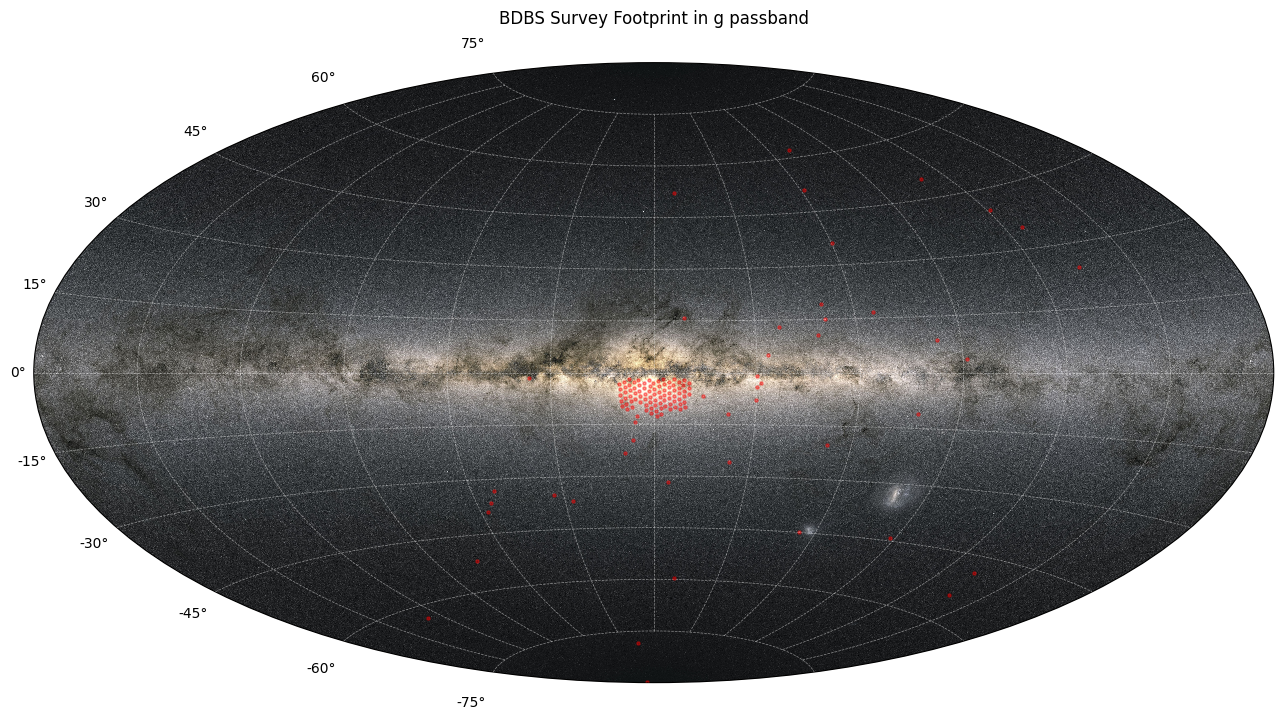

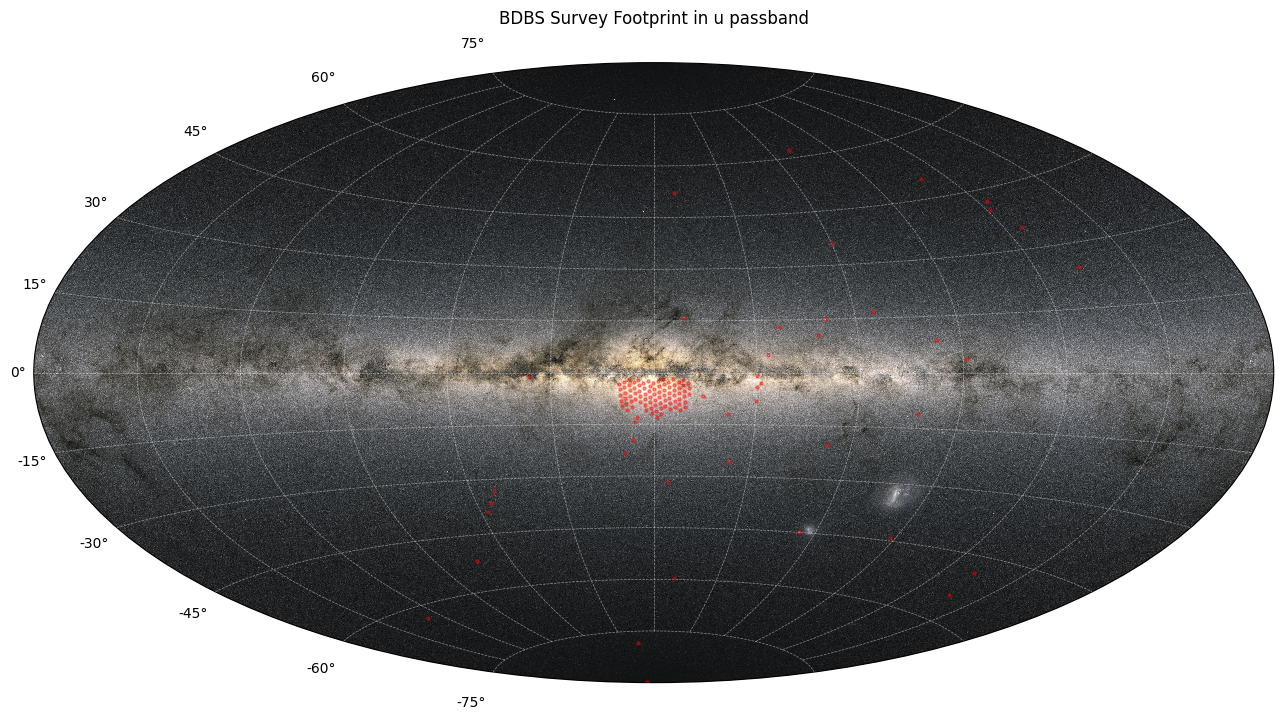

In [47]:
for f, pointing_set in bdbs_footprint.items():
    mw1 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic', background='optical', figsize=(16,10))
    mw1.title = 'BDBS Survey Footprint in ' + f + ' passband'
    proj = HEALPix(nside=64, order='ring', frame='icrs')

    data = np.array(pointing_set)
    s = SkyCoord(data[:,0], data[:,1], frame='icrs', unit=(u.deg, u.deg))
    mw1.scatter(s.ra.deg*u.deg, s.dec.deg*u.deg, c='r', s=5, alpha=0.4)


From the pointings and plots it is clear that the survey footprint is almost the same in all filters, but not quite.  

For our purposes we need the superset of pointings, effectively combining the pointing for all filters. 

In [55]:
data = []
for f, pointing_set in bdbs_footprint.items():
    data += pointing_set

all_pointings = SkyCoord(np.array(data)[:,0], np.array(data)[:,1], frame='icrs', unit=(u.deg, u.deg))

uniqs = []
uniq_pointings = []
for i in range(0,len(data),1):
    entry = data[i]
    
    s = SkyCoord(entry[0], entry[1], frame='icrs', unit=(u.deg, u.deg))
    
    if i == 0:
        uniq_pointings.append(entry)
    else:
        uniqs = SkyCoord(np.array(uniq_pointings)[:,0], np.array(uniq_pointings)[:,1], frame='icrs', unit=(u.deg, u.deg))
        sep = s.separation(uniqs)
        idx = np.where(sep.value <= 0.5)[0]
        if len(idx) == 0:
            uniq_pointings.append(entry)

bdbs_all_footprint = uniq_pointings

print(str(len(bdbs_all_footprint)) + ' unique pointings (all filters)')
bdbs_all_footprint

139 unique pointings (all filters)


[[279.308417, -35.712611],
 [272.349083, -31.435111],
 [270.887, -30.036556],
 [277.741958, -36.585611],
 [201.363042, -43.018639],
 [279.00325, -33.9165],
 [130.747375, -0.010278],
 [162.000458, -0.001222],
 [272.619667, -32.245944],
 [275.704458, -32.179361],
 [271.051208, -31.381694],
 [275.865458, -33.980222],
 [277.339375, -33.114361],
 [277.534333, -34.841],
 [327.992333, 0.004222],
 [274.22525, -33.111444],
 [140.683167, -45.252306],
 [220.500375, -0.08075],
 [320.991083, 0.005722],
 [269.556042, -28.784111],
 [269.52175, -30.517333],
 [272.615458, -30.4455],
 [268.066333, -34.84625],
 [282.0715, -30.430167],
 [266.4985, -33.979917],
 [269.603792, -35.64075],
 [245.792958, -55.324111],
 [270.910875, -26.190083],
 [271.255708, -36.577167],
 [275.440083, -28.71875],
 [273.977333, -27.851056],
 [272.394125, -26.982889],
 [190.0015, -11.700944],
 [284.071083, -30.498917],
 [269.641, -33.914167],
 [269.545167, -32.181694],
 [266.460417, -32.180222],
 [301.844333, -44.616972],
 [271.1

Output the set of unique pointings per filter in CSV format.

In [62]:
output_file = '/Users/rstreet/software/rgps/config/BDBS_survey_pointings.csv'

with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['RA[Deg]','Dec[deg]'])
    writer.writerows(bdbs_all_footprint)


For future use, it is most convenient to convert this set of pointings into an HEALpixel array, since this saves repeatedly converting it. 

In [59]:
proj = HEALPix(nside=64, order='ring', frame='icrs')
s = SkyCoord(np.array(bdbs_all_footprint)[:,0], np.array(bdbs_all_footprint)[:,1], frame='icrs', unit=(u.deg, u.deg))
hpix = proj.skycoord_to_healpix(s)
hpix

array([38982, 37441, 36928, 39493, 41478, 38470, 24540, 24563, 37698,
       37700, 37440, 38212, 38213, 38725, 24681, 38211, 41925, 24604,
       24676, 36415, 37184, 37186, 38719, 36936, 38461, 38975, 44768,
       35392, 39233, 36419, 36163, 35905, 29447, 37194, 38463, 37696,
       37949, 41792, 38209, 38721, 36417, 39746, 36675, 37438, 36161,
       36677, 38210, 35394, 39231, 38716, 35138, 38973, 39487, 35907,
       36165, 37188, 42667, 24580, 42407, 24549, 40258, 35591, 40252,
       24693, 40768, 41025, 38722, 40770, 35631, 40251, 39739, 45839,
       42190, 36006, 40509, 24458, 24679, 41819, 39228, 40256, 37202,
       39740, 39997, 40257, 39998, 40510, 39235, 39745, 43759, 40003,
       39485, 35465, 38980, 43564, 34371, 35142, 35140, 34373, 38723,
       34115, 34884, 35396, 47953, 34886, 34882, 37445, 37702, 34369,
       24554, 46824, 37442, 34117, 42008, 35655, 37950, 35656, 41979,
       35654, 33859, 36167, 48915, 35144, 36480, 23627, 44186, 44766,
       45735, 44396,

Lastly, output the HEALpixel array in the same JSON format used for other surveys.

In [65]:
skymap = np.zeros(proj.npix)
skymap[hpix] = 1.0

jdata = {
    "nside": 64,
    "healpix_resolution_deg": 0.8392936452111668,
    "n_healpix": 49152,
    "healpix_map": skymap.tolist()
}

output_file = '/Users/rstreet/software/rgps/config/BDBS_survey_footprint.json'
with open(output_file, 'w') as f:
    json.dump(jdata, f, indent=4)

The MADGICS Catalog of DIPs

The MADGICs catalog consists of >2.6 million objects so this has been distilled into a HEALpixel map of the number of known objects per HEALpixel. 

In [6]:
input_file = '/Users/rstreet/software/rgps/config/MADGICS_object_map.json'
with open(input_file, 'r') as f:
    jdata = json.load(f)

skymap = np.array(jdata['healpix_map'])
skymap

array([0., 0., 0., ..., 0., 0., 0.])

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_8793/731816131.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

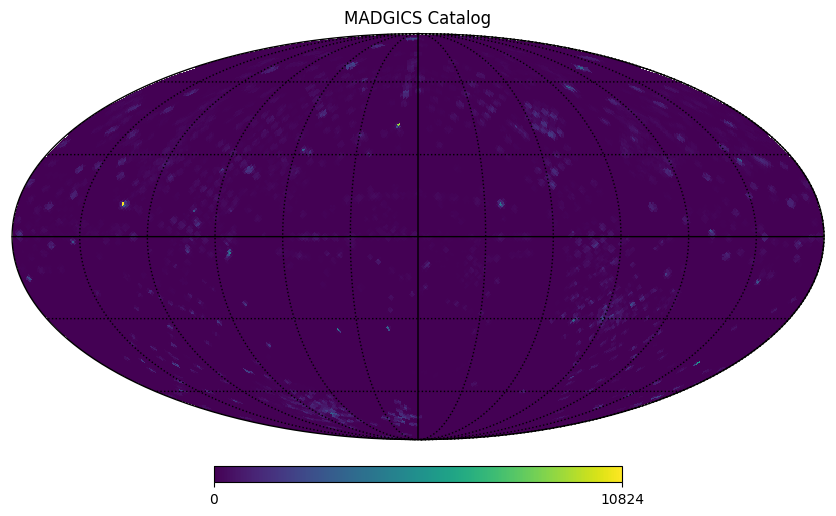

In [10]:
fig = plt.figure(1,(10,10))
hp.mollview(skymap, title='MADGICS Catalog')
hp.graticule()
plt.tight_layout()